In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
repayment_data = pd.read_csv("../data/repayment_data.csv", sep=";")

In [4]:
repayment_data.head()

,ID,month,max_delay,status
0,anon_S0,2002-11-30,0,1
1,anon_S0,2002-12-31,0,1
2,anon_S0,2003-01-31,0,1
3,anon_S0,2003-02-28,0,1
4,anon_S0,2003-03-31,0,1


In [5]:
repayment_data.shape

(530952, 4)

In [6]:
repayment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530952 entries, 0 to 530951
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         530952 non-null  object
 1   month      530952 non-null  object
 2   max_delay  530952 non-null  int64 
 3   status     530952 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 16.2+ MB


In [7]:
repayment_data.describe(include='all')

,ID,month,max_delay,status
count,530952,530952,530952.000000,530952.000000
unique,32551,64,NaN,NaN
top,anon_S1,2008-02-29,NaN,NaN
freq,60,26152,NaN,NaN
mean,NaN,NaN,2.881097,1.149769
std,NaN,NaN,12.406193,0.525092
min,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,0.000000,1.000000
50%,NaN,NaN,0.000000,1.000000
75%,NaN,NaN,0.000000,1.000000


In [8]:
repayment_data['month'].min()

'2002-11-30'

In [9]:
repayment_data['month'].max()

'2008-02-29'

In [10]:
len(repayment_data[repayment_data['status']==5]['ID'].unique())

3121

# Feature engineering

In [11]:
repayment_data['delayed'] = np.where(repayment_data['max_delay']>0, 1, 0)

In [12]:
repayment_data['month'] = pd.to_datetime(repayment_data['month'])

In [13]:
users_first_month = repayment_data.groupby(['ID'], as_index=False)['month'].min()
users_first_month.rename({'month': 'first_month'}, axis=1, inplace=True)

In [14]:
repayment_data = pd.merge(repayment_data, users_first_month, on = ['ID'])

In [15]:
repayment_data['month_number'] = 1+ np.round((repayment_data['month'] - repayment_data['first_month'])/np.timedelta64(1, 'M')) 

In [16]:
repayment_data.drop(['first_month'], axis=1, inplace=True)

# Rolling window statistics

In [17]:
def rolling_sum(df, col):
    df.sort_values(['ID', 'month'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    roll_df = pd.DataFrame(df.groupby(['ID'])[col].apply(lambda x: x.rolling(window=7, min_periods=1).sum()))
    new_column_name=col+'_roll_sum'
    roll_df.columns = [new_column_name]
    
    return pd.merge(df, roll_df[[new_column_name]], 
                    left_index=True, right_index=True)
    

In [18]:
def rolling_max(df, col):
    df.sort_values(['ID', 'month'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    roll_df = pd.DataFrame(df.groupby(['ID'])[col].apply(lambda x: x.rolling(window=7, min_periods=1).max()))
    new_column_name=col+'_roll_max'
    roll_df.columns = [new_column_name]
    
    return pd.merge(df, roll_df[[new_column_name]], 
                    left_index=True, right_index=True)

In [19]:
def rolling_mean(df, col):
    df.sort_values(['ID', 'month'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    roll_df = pd.DataFrame(df.groupby(['ID'])[col].apply(lambda x: x.rolling(window=7, min_periods=1).mean()))
    new_column_name=col+'_roll_mean'
    roll_df.columns = [new_column_name]
    
    return pd.merge(df, roll_df[[new_column_name]], 
                    left_index=True, right_index=True)

In [20]:
repayment_data = rolling_sum(repayment_data, 'delayed')

In [21]:
repayment_data = rolling_mean(repayment_data, 'max_delay')
repayment_data = rolling_max(repayment_data, 'max_delay')
repayment_data = rolling_max(repayment_data, 'status')

# Create target variable

In [22]:
def rolling_max_backwards(df, col):
    df.sort_values(['ID', 'month'], ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    roll_df = pd.DataFrame(df.groupby(['ID'])[col].apply(lambda x: x.rolling(window=7, min_periods=1).max()))
    new_column_name=col+'_roll_max_future'
    roll_df.columns = [new_column_name]
    
    return pd.merge(df, roll_df[[new_column_name]], 
                    left_index=True, right_index=True)

In [23]:
repayment_data = rolling_max_backwards(repayment_data, 
                                       'status').sort_values(['ID', 'month'])

In [24]:
repayment_data['default'] = np.where(repayment_data['status_roll_max_future']==5, 1, 0)

# Drop columns where target is not known (no 6 month future is available)

In [25]:
repayment_data = repayment_data[(repayment_data['month']<=('2007-08-31 00:00:00'))|
                               (repayment_data['default']==1)]

In [26]:
repayment_data.shape

(382598, 12)

In [27]:
repayment_data = repayment_data[repayment_data['status']<5]

In [28]:
repayment_data.shape

(379476, 12)

In [29]:
repayment_data[repayment_data['ID']=='anon_S10010'].head(25)

,ID,month,max_delay,status,delayed,month_number,delayed_roll_sum,max_delay_roll_mean,max_delay_roll_max,status_roll_max,status_roll_max_future,default
530524,anon_S10010,2006-02-28,0,1,0,1.0,0.0,0.000000,0.0,1.0,1.0,0
530523,anon_S10010,2006-03-31,0,1,0,2.0,0.0,0.000000,0.0,1.0,1.0,0
530522,anon_S10010,2006-04-30,0,1,0,3.0,0.0,0.000000,0.0,1.0,1.0,0
530521,anon_S10010,2006-05-31,0,1,0,4.0,0.0,0.000000,0.0,1.0,1.0,0
530520,anon_S10010,2006-06-30,0,1,0,5.0,0.0,0.000000,0.0,1.0,1.0,0
530519,anon_S10010,2006-07-31,0,1,0,6.0,0.0,0.000000,0.0,1.0,1.0,0
530518,anon_S10010,2006-08-31,0,1,0,7.0,0.0,0.000000,0.0,1.0,2.0,0
530517,anon_S10010,2006-09-30,0,1,0,8.0,0.0,0.000000,0.0,1.0,3.0,0
530516,anon_S10010,2006-10-31,0,1,0,9.0,0.0,0.000000,0.0,1.0,3.0,0
530515,anon_S10010,2006-11-30,0,1,0,10.0,0.0,0.000000,0.0,1.0,3.0,0


# Read customer data

In [30]:
customer_data = pd.read_csv("../data/customer_data.csv", sep = ";")

In [31]:
customer_data.head(3)

,ID,debt_amount,own_resource,duration,payment_type,car_age,brand,engine_capacity_cat,birth_date,residence_type,region
0,anon_S0,Between_2.25M-3M,15.0,7,postal_check,0,SEAT,Between_1.1-1.3,11/15/1952 00:00:00,county seat,Central Transdanubia
1,anon_S1,Between_1.5M-2.25M,20.0,60,postal_check,0,CITROEN,Below_1.1,02/04/1975 00:00:00,county seat,Central Transdanubia
2,anon_S10,Between_1.5M-2.25M,25.0,60,postal_check,0,PEUGEOT,Between_1.3-1.5,03/22/1978 00:00:00,municipality,Western Transdanubia


In [32]:
data = pd.merge(repayment_data, customer_data, on= ['ID'], how='inner')

In [33]:
data.shape

(379476, 22)

In [34]:
data['car_used'] = np.where(data['car_age']<12, 0, 1)

<AxesSubplot:>

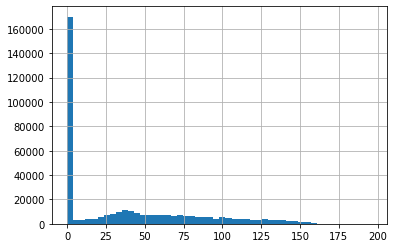

In [35]:
data['car_age'].hist(bins=50)

In [36]:
data['customer_age'] = (data['month'] -pd.to_datetime(data['birth_date'],
                        format='%m/%d/%Y %H:%M:%S'))/np.timedelta64(1, 'Y')

In [37]:
data.head(3)

,ID,month,max_delay,status,delayed,month_number,delayed_roll_sum,max_delay_roll_mean,max_delay_roll_max,status_roll_max,...,duration,payment_type,car_age,brand,engine_capacity_cat,birth_date,residence_type,region,car_used,customer_age
0,anon_S0,2002-11-30,0,1,0,1.0,0.0,0.0,0.0,1.0,...,7,postal_check,0,SEAT,Between_1.1-1.3,11/15/1952 00:00:00,county seat,Central Transdanubia,0,50.040726
1,anon_S0,2002-12-31,0,1,0,2.0,0.0,0.0,0.0,1.0,...,7,postal_check,0,SEAT,Between_1.1-1.3,11/15/1952 00:00:00,county seat,Central Transdanubia,0,50.125601
2,anon_S0,2003-01-31,0,1,0,3.0,0.0,0.0,0.0,1.0,...,7,postal_check,0,SEAT,Between_1.1-1.3,11/15/1952 00:00:00,county seat,Central Transdanubia,0,50.210477


In [38]:
data['payment_type'].value_counts()

postal_check     372276
bank_transfer      5575
direct_debit       1625
Name: payment_type, dtype: int64

In [39]:
data['brand'].value_counts()

SUZUKI           149192
OPEL              31205
RENAULT           27045
SKODA             26025
VW                19934
FORD              14961
FIAT              12805
PEUGEOT            9454
SEAT               9353
CHEVROLET          8829
HONDA              8608
CITROEN            7950
HYUNDAI            7726
KIA                5812
NISSAN             5807
MAZDA              5505
AUDI               5391
MITSUBISHI         5345
TOYOTA             5081
DACIA              4190
ALFA               2575
DAEWOO             2376
VOLVO              2301
ROVER               751
SAAB                453
CHRYSLER            417
MERCEDES-BENZ       237
BMW                 148
Name: brand, dtype: int64

# Create train and test partitions

In [40]:
import random
import math

In [41]:
user_list = list(data['ID'].unique())
sample_size = math.floor(len(user_list)*0.85)
train_users = random.sample(user_list, sample_size)

train_data = data[data['ID'].isin(train_users)]
test_data = data[~data['ID'].isin(train_users)]

In [42]:
cv = pd.DataFrame(zip(train_users, 
                      np.random.randint(1,6, len(train_users))), 
                  columns = ['ID', 'CV'])

train_data = pd.merge(train_data, cv, on=['ID'])

In [43]:
train_data.head(3)

,ID,month,max_delay,status,delayed,month_number,delayed_roll_sum,max_delay_roll_mean,max_delay_roll_max,status_roll_max,...,payment_type,car_age,brand,engine_capacity_cat,birth_date,residence_type,region,car_used,customer_age,CV
0,anon_S0,2002-11-30,0,1,0,1.0,0.0,0.0,0.0,1.0,...,postal_check,0,SEAT,Between_1.1-1.3,11/15/1952 00:00:00,county seat,Central Transdanubia,0,50.040726,2
1,anon_S0,2002-12-31,0,1,0,2.0,0.0,0.0,0.0,1.0,...,postal_check,0,SEAT,Between_1.1-1.3,11/15/1952 00:00:00,county seat,Central Transdanubia,0,50.125601,2
2,anon_S0,2003-01-31,0,1,0,3.0,0.0,0.0,0.0,1.0,...,postal_check,0,SEAT,Between_1.1-1.3,11/15/1952 00:00:00,county seat,Central Transdanubia,0,50.210477,2


# Explore the brands on train data

In [44]:
brand_df = train_data.groupby('brand').agg({'default': ['sum','count'], 
                                            'car_used':'sum'})
brand_df.columns = ['default_nr', 'total_count', 'used_nr']

brand_df['default_ratio'] = brand_df['default_nr']/brand_df['total_count']
brand_df['used_ratio'] = brand_df['used_nr']/brand_df['total_count']
brand_df.sort_values(['default_ratio'], ascending=False, inplace=True)

In [45]:
brand_cat1 = list(brand_df[brand_df['default_ratio']>0.08].index)
brand_cat2 = list(brand_df[(brand_df['default_ratio']<=0.08) & 
                           (brand_df['default_ratio']>0.05)].index)
brand_cat3 = list(brand_df[brand_df['default_ratio']<=0.05].index)

In [46]:
brand_cat3

['SEAT',
 'HYUNDAI',
 'MAZDA',
 'HONDA',
 'DAEWOO',
 'RENAULT',
 'SUZUKI',
 'SKODA',
 'TOYOTA',
 'DACIA',
 'BMW',
 'MERCEDES-BENZ']

In [47]:
def add_brand_category(df):
    df['brand_cat'] = np.where(df['brand'].isin(['SAAB', 
                                                'CHRYSLER',
                                                'ALFA',
                                                'BMW']), 
                               'brand_cat1', 'brand_cat2')
    df['brand_cat'] = np.where(df['brand'].isin(['NISSAN',
 'OPEL',
 'HYUNDAI',
 'HONDA',
 'DAEWOO',
 'RENAULT',
 'SUZUKI',
 'SKODA',
 'TOYOTA',
 'DACIA',
 'MERCEDES-BENZ']), 'brand_cat3', df['brand_cat'])
    return df
                               
    

In [48]:
train_data = add_brand_category(train_data)

In [49]:
test_data = add_brand_category(test_data)

In [50]:
train_data.head(3)

,ID,month,max_delay,status,delayed,month_number,delayed_roll_sum,max_delay_roll_mean,max_delay_roll_max,status_roll_max,...,car_age,brand,engine_capacity_cat,birth_date,residence_type,region,car_used,customer_age,CV,brand_cat
0,anon_S0,2002-11-30,0,1,0,1.0,0.0,0.0,0.0,1.0,...,0,SEAT,Between_1.1-1.3,11/15/1952 00:00:00,county seat,Central Transdanubia,0,50.040726,2,brand_cat2
1,anon_S0,2002-12-31,0,1,0,2.0,0.0,0.0,0.0,1.0,...,0,SEAT,Between_1.1-1.3,11/15/1952 00:00:00,county seat,Central Transdanubia,0,50.125601,2,brand_cat2
2,anon_S0,2003-01-31,0,1,0,3.0,0.0,0.0,0.0,1.0,...,0,SEAT,Between_1.1-1.3,11/15/1952 00:00:00,county seat,Central Transdanubia,0,50.210477,2,brand_cat2


# Add dummy variables

In [51]:
train_data.columns

Index(['ID', 'month', 'max_delay', 'status', 'delayed', 'month_number',
       'delayed_roll_sum', 'max_delay_roll_mean', 'max_delay_roll_max',
       'status_roll_max', 'status_roll_max_future', 'default', 'debt_amount',
       'own_resource', 'duration', 'payment_type', 'car_age', 'brand',
       'engine_capacity_cat', 'birth_date', 'residence_type', 'region',
       'car_used', 'customer_age', 'CV', 'brand_cat'],
      dtype='object')

In [52]:
categorical_columns = ['debt_amount','payment_type', 'engine_capacity_cat',
                      'residence_type', 'region','brand_cat']

In [53]:
for column in categorical_columns:
    dummies = pd.get_dummies(train_data[column])
    train_data = pd.concat([train_data, dummies], axis=1)

In [54]:
for column in categorical_columns:
    dummies = pd.get_dummies(test_data[column])
    test_data = pd.concat([test_data, dummies], axis=1)

# Feature selection

In [55]:
feature_columns = ['month_number', 'max_delay', 'status', 'delayed', 'delayed_roll_sum', 'max_delay_roll_mean',
                   'max_delay_roll_max', 'status_roll_max', 'own_resource', 'duration', 'car_age', 'customer_age', 'car_used',
                  'bank_transfer', 'direct_debit', 'postal_check', 'Above_1.8', 'Below_1.1', 'Between_1.1-1.3',
                   'Between_1.3-1.5', 'Between_1.5-1.8', 'capital', 'city', 'county seat', 'large village', 'municipality', 
                   'Central Hungary', 'Central Transdanubia', 'Northern Alfold', 'Northern Hungary', 'Southern Alfold', 
                   'Southern Transdanubia', 'Western Transdanubia', 'brand_cat1', 'brand_cat2', 'brand_cat3', 'Above_3M', 
                   'Below_0.75M', 'Between_0.75M-1.5M', 'Between_1.5M-2.25M', 'Between_2.25M-3M'
                  ]

In [56]:
len(feature_columns)

41

In [57]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [58]:
feature_slector_chi2 = SelectKBest(chi2, k=15)
feature_slector_chi2.fit_transform(train_data[feature_columns], train_data['default'])
selection_chi2 = np.array(feature_columns)[feature_slector_chi2.get_support()]
selection_chi2

array(['month_number', 'max_delay', 'status', 'delayed',
       'delayed_roll_sum', 'max_delay_roll_mean', 'max_delay_roll_max',
       'status_roll_max', 'own_resource', 'duration', 'car_age',
       'customer_age', 'Above_1.8', 'brand_cat1', 'brand_cat2'],
      dtype='<U21')

In [59]:
feature_slector_f_classif = SelectKBest(f_classif, k=15)
feature_slector_f_classif.fit_transform(train_data[feature_columns], train_data['default'])
selection_f_classif = np.array(feature_columns)[feature_slector_f_classif.get_support()]
selection_f_classif

array(['max_delay', 'status', 'delayed', 'delayed_roll_sum',
       'max_delay_roll_mean', 'max_delay_roll_max', 'status_roll_max',
       'own_resource', 'car_age', 'customer_age', 'car_used', 'Above_1.8',
       'brand_cat1', 'brand_cat2', 'brand_cat3'], dtype='<U21')

In [60]:
selected_variables = list(set(selection_chi2).union(set(selection_f_classif)))
selected_variables

['max_delay_roll_mean',
 'duration',
 'status',
 'brand_cat2',
 'status_roll_max',
 'delayed_roll_sum',
 'customer_age',
 'car_age',
 'max_delay',
 'delayed',
 'max_delay_roll_max',
 'own_resource',
 'car_used',
 'month_number',
 'brand_cat1',
 'Above_1.8',
 'brand_cat3']

In [61]:
len(selected_variables)

17

# Hyperparameter serach with cross validation

In [62]:
train_data['CV'].value_counts()

2    67471
3    65985
1    63494
4    63195
5    61963
Name: CV, dtype: int64

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [64]:
X_train = train_data[selected_variables]
y_train = train_data['default']

In [ ]:
# Cross validation - we use the predefined user-level partition that is stored in the train_data['CV'] column

result_df = pd.DataFrame(columns=['NrVar', 'r1', 'r2', 'r3', 'r4', 'r5'])
logreg = LogisticRegression()
for i in [5, 10, 12, 14, 16, 17]:
    selector = RFE(logreg, i, step=1)
    selector = selector.fit(X_train, y_train)
    scores = cross_val_score(logreg,X_train[X_train.columns[selector.support_]] , 
                             y_train, groups=train_data['CV'], scoring='roc_auc')
    result_df = result_df.append(pd.DataFrame([[i, *scores]], 
                                              columns=['NrVar', 'r1', 'r2', 'r3', 'r4', 'r5']))
    print("Number of variables used: " +str(i)+", ROC: " + str(scores.mean()))
result_df['ROC_avg'] = result_df[[ 'r1', 'r2', 'r3', 'r4', 'r5']].mean(axis=1)
result_df

Number of variables used: 5, ROC: 0.8561521118952105
Number of variables used: 10, ROC: 0.8704405197498402
Number of variables used: 12, ROC: 0.8776862159714065
Number of variables used: 14, ROC: 0.8742871650918758


# Build model on whole training data with the best parameters

In [ ]:
logreg = LogisticRegression()
selector = RFE(logreg, 14, step=1)
selector = selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.support_]
selected_features
logreg.fit(X_train[selected_features], y_train)

In [ ]:
import pickle

pickle.dump(logreg, open('LogRegModel.pkl', 'wb'))

In [ ]:
selected_features

# Evaluate model

In [ ]:
train_pred_df = X_train[selected_features]
train_pred_df['predicted'] = logreg.predict_proba(train_pred_df)[:, 1]
train_pred_df['target']= y_train
roc_auc_score(train_pred_df['target'], train_pred_df['predicted'])

In [ ]:
X_test = test_data[selected_features]
y_test = test_data['default']

test_pred_df = X_test.copy()
test_pred_df['predicted'] = logreg.predict_proba(test_pred_df)[:, 1]
test_pred_df['target']= y_test
roc_auc_score(test_pred_df['target'], test_pred_df['predicted'])

## Kolmogorov-Smirnov

In [ ]:
def calculate_KS(df):
    
    good_df = pd.DataFrame(df[df['target']==0].groupby(['predicted']).size(), columns=['good_count']).reset_index()
    bad_df = pd.DataFrame(df[df['target']==1].groupby(['predicted']).size(), columns=['bad_count']).reset_index()
    all_scores_df = pd.merge(good_df, bad_df, on =['predicted'], how='outer').fillna(0).sort_values('predicted')
    all_scores_df['good_cumsum'] = all_scores_df['good_count'].cumsum()
    all_scores_df['bad_cumsum'] = all_scores_df['bad_count'].cumsum()
    all_scores_df['good_ratio'] = all_scores_df['good_cumsum']/(all_scores_df['good_count'].sum())
    all_scores_df['bad_ratio'] = all_scores_df['bad_cumsum']/(all_scores_df['bad_count'].sum())
    all_scores_df['difference'] = all_scores_df['good_ratio'] - all_scores_df['bad_ratio']
    
    KS_index = all_scores_df['difference'].max()
    best_score = all_scores_df.loc[all_scores_df['difference'].argmax()]['predicted']
    result_df = all_scores_df[['predicted', 'good_cumsum', 'bad_cumsum', 'good_ratio', 'bad_ratio', 'difference']]
    
    return KS_index, best_score, result_df

In [ ]:
(ks_train, best_score_train, train_KS_df) = calculate_KS(train_pred_df)

In [ ]:
ks_train

In [ ]:
best_score_train

In [ ]:
from plotnine import *

In [ ]:
ggplot(data = train_KS_df) + aes(x="predicted", y="good_ratio") + geom_line(color='green') +\
geom_line(mapping=aes(x="predicted", y="bad_ratio") ,color='red') +\
geom_vline(xintercept=best_score_train, color='blue', linetype='dotted')

In [ ]:
train_KS_df[train_KS_df["predicted"]>=best_score_train].head(1)

In [ ]:
train_pred_df.head()

### Set cut-off and check the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
train_pred_df['predicted_category'] = np.where(train_pred_df['predicted']> best_score_train, 1, 0)

In [ ]:
confusion_matrix(train_pred_df['target'], train_pred_df['predicted_category'])

In [ ]:
# within row normalization
confusion_matrix(train_pred_df['target'], train_pred_df['predicted_category'], normalize ='true')

In [ ]:
confusion_matrix(train_pred_df['target'], train_pred_df['predicted_category'], normalize ='all')

In [ ]:
accuracy_score(train_pred_df['target'], train_pred_df['predicted_category'])

#### Validate KS on test

In [ ]:
(ks_test, best_score_test, test_KS_df) = calculate_KS(test_pred_df)

In [ ]:
ks_test

In [ ]:
best_score_test

In [ ]:
test_KS_df[test_KS_df["predicted"]>=best_score_train].head(1)

In [ ]:
ggplot(data = test_KS_df) + aes(x="predicted", y="good_ratio") + geom_line(color='green') +\
geom_line(mapping=aes(x="predicted", y="bad_ratio") ,color='red') +\
geom_vline(xintercept=best_score_train, color='orange', linetype='dotted') +\
geom_vline(xintercept=best_score_test, color='purple', linetype='dotted')

In [ ]:
test_pred_df['predicted_category'] = np.where(test_pred_df['predicted']> best_score_train, 1, 0)

In [ ]:
confusion_matrix(test_pred_df['target'], test_pred_df['predicted_category'])

In [ ]:
confusion_matrix(test_pred_df['target'], test_pred_df['predicted_category'], normalize ='true')

In [ ]:
confusion_matrix(test_pred_df['target'], test_pred_df['predicted_category'], normalize ='all')

In [ ]:
accuracy_score(test_pred_df['target'], test_pred_df['predicted_category'])